<a href="https://colab.research.google.com/github/Vihangip/CPSC-425/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal, ndimage
import ncc

# Part 1: Face Detection



## *Question 2*

In [2]:
def MakeGaussianPyramid(image, scale=0.75, minsize=30):
    pyramid = [image]  #initialize pyramid
    current_image = np.asarray(image)

    while True:
        # calculate new dimensions
        new_size = (int(current_image.shape[1] * scale), int(current_image.shape[0] * scale))

        # stop if the new dimensions are smaller than minsize
        if min(new_size) < minsize:
            break

        # resize image
        resized_image = image.resize(new_size, Image.BICUBIC)

        # apply Gaussian filter
        sigma = 1 / (2 * scale)
        if image.mode == 'RGB':
            # split rgb channels, apply filter, and merge back
            r, g, b = resized_image.split()
            r = Image.fromarray(ndimage.gaussian_filter(np.array(r), sigma).astype(np.uint8))
            g = Image.fromarray(ndimage.gaussian_filter(np.array(g), sigma).astype(np.uint8))
            b = Image.fromarray(ndimage.gaussian_filter(np.array(b), sigma).astype(np.uint8))
            filtered_image = Image.merge("RGB", (r, g, b))
        else:
            filtered_image = Image.fromarray(ndimage.gaussian_filter(np.array(resized_image), sigma))

        # add filtered image to pyramid
        pyramid.append(filtered_image)
        current_image = np.asarray(filtered_image)

    return pyramid



## *Question 3*

In [54]:
# joins images in the given pyramid and displays it
def ShowGaussianPyramid(pyramid):
  # calculating shape of output image
  total_width = 0
  max_height = 0
  for image in pyramid:
    total_width += image.width
    if image.height > max_height:
      max_height = image.height

  # creating a blank output image with white background
  if pyramid[0].mode == 'RGB':
      mode = 'RGB'
      new_image = Image.new(mode, (total_width, max_height), (255, 255, 255))
  else:
      mode = 'L'
      new_image = Image.new(mode, (total_width, max_height), 255)

  # pasting images in pyramid to output image
  offset_x = 0

  for image in pyramid:
    new_image.paste(image, (offset_x, 0))
    offset_x += image.width

  display(new_image)


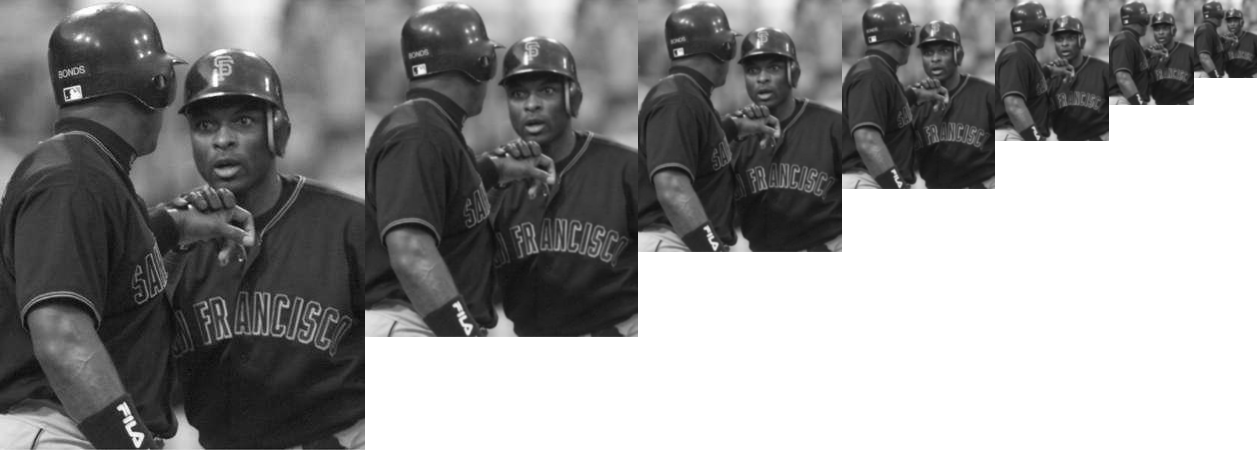

In [4]:
sports = Image.open('sports.jpg')
pyramid_image = MakeGaussianPyramid(sports, 0.75, 50)
ShowGaussianPyramid(pyramid_image)

## *Question 4*

In [5]:
def FindTemplate(pyramid, template, threshold):
  # resizing template while maintaining aspect ratio
  reduced_template_width = 15
  scaling_factor = reduced_template_width/template.width
  new_height = int(scaling_factor * template.height)
  new_width = int(scaling_factor * template.width)
  resized_template = template.resize((new_width, new_height), Image.BICUBIC)

  points = []

  for i,image in enumerate(pyramid):
    ncc_array = ncc.normxcorr2D(image, resized_template)  # compute normalized cross-correlation

    # check each point to see if it exceeds the threshold
    for x in range(image.width):
      for y in range(image.height):
        if ncc_array[y][x] > threshold:
          points.append((x/(0.75**i), y/(0.75**i)))  # if it exceeds, adds to points array after adjusting to scale factor

  image = pyramid[0]
  image = image.convert("RGB")

  # draw boxes around matched points
  for p in points:
    draw = ImageDraw.Draw(image)
    x1 = p[0]-20
    x2 = p[0]+20
    y1 = p[1]-25
    y2 = p[1]+25
    draw.line((x1,y1,x1,y2),fill="red",width=2) # left vertical line
    draw.line((x2,y1,x2,y2),fill="red",width=2) # right vertical line
    draw.line((x1,y1,x2,y1),fill="red",width=2) # top horizontal line
    draw.line((x1,y2,x2,y2),fill="red",width=2) # bottom horizontal line
    del draw # reset draw object

  return image

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


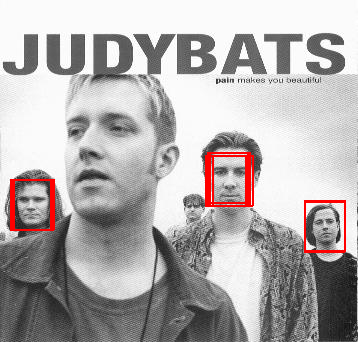

In [6]:
judybats = Image.open('judybats.jpg')
template = Image.open('template.jpg')
pyramid = MakeGaussianPyramid(judybats, 0.75, 50)
output = FindTemplate(pyramid, template, 0.7)
display(output)

## *Question 5*

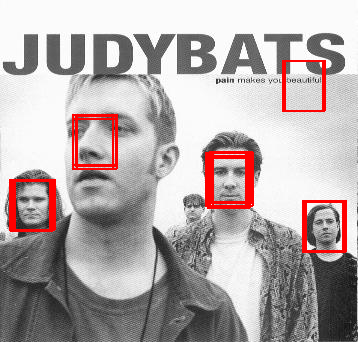

error rate 1/1


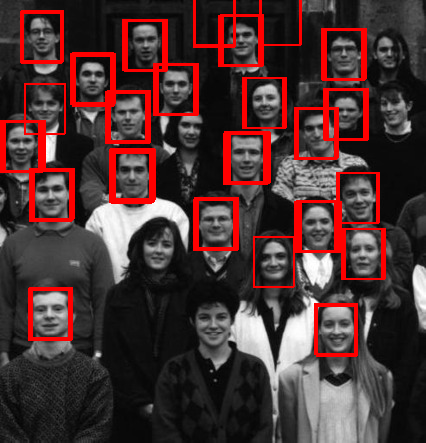

error rate 2/5


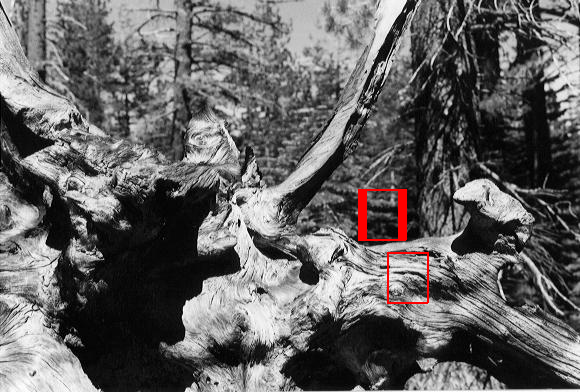

error rate 2/0


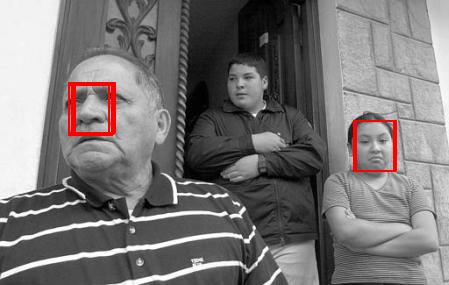

error rate 2/1


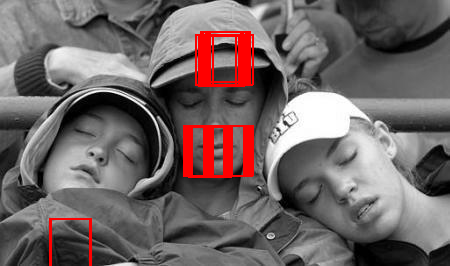

error rate 4/3


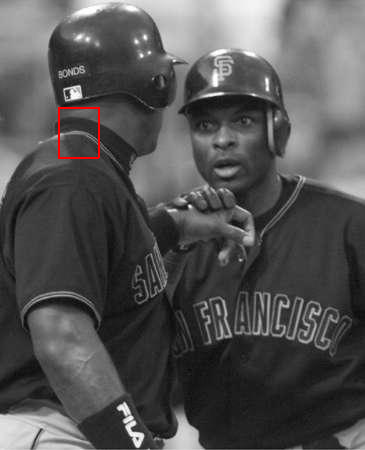

error rate 1/1


In [7]:
threshold = 0.6

judybats = Image.open('judybats.jpg')
judybats_pyramid = MakeGaussianPyramid(judybats, 0.75, 50)
judybats_output = FindTemplate(judybats_pyramid, template, threshold)

students = Image.open('students.jpg')
students_pyramid = MakeGaussianPyramid(students, 0.75, 50)
students_output = FindTemplate(students_pyramid, template, threshold)

tree = Image.open('tree.jpg')
tree_pyramid = MakeGaussianPyramid(tree, 0.75, 50)
tree_output = FindTemplate(tree_pyramid, template, threshold)

family = Image.open('family.jpg')
family_pyramid = MakeGaussianPyramid(family, 0.75, 50)
family_output = FindTemplate(family_pyramid, template, threshold)

fans = Image.open('fans.jpg')
fans_pyramid = MakeGaussianPyramid(fans, 0.75, 50)
fans_output = FindTemplate(fans_pyramid, template, threshold)

sports = Image.open('sports.jpg')
sports_pyramid = MakeGaussianPyramid(sports, 0.75, 50)
sports_output = FindTemplate(sports_pyramid, template, threshold)

display(judybats_output)
print("error rate 1/1")
display(students_output)
print("error rate 2/5")
display(tree_output)
print("error rate 2/0")
display(family_output)
print("error rate 2/1")
display(fans_output)
print("error rate 4/3")
display(sports_output)
print("error rate 1/1")

## *Question 6*

Recall Rates:



* judybats = 4/5
* students = 23/27
* tree = 0/0
* family = 2/3
* fans = 0/3
* sports = 0/1

The recall rate is low for some images because the provided template features a fully visible, front-facing face with a neutral expression. In contrast, some images lack a fully visible face and display different emotions or accessories, leading to poor template matching.







# Part 2: Image Blending



## *Question 2*

In [53]:
def MakeLaplacianPyramid(image, scale, minsize):
  gaussian_pyramid = MakeGaussianPyramid(image, scale, minsize)
  laplacian_pyramid = []

  # iterate through each image in gaussian pyramid except last one
  for i in range(len(gaussian_pyramid)-1):
    layer_image = gaussian_pyramid[i]
    width = int(layer_image.width)
    height = int(layer_image.height)

    next = gaussian_pyramid[i+1]

    # upsample the next Gaussian image to the current level's size
    unsampled_image = np.array(Image.fromarray(np.uint8(next)).resize((width,height), Image.BICUBIC)).astype(np.float32)
    # compute the lap layer by subtracting the upsampled gaus image from the current one
    laplacian_layer = np.array(layer_image).astype(np.float32) - unsampled_image
    # clip values between [0,255] to avoid artifacts
    laplacian_layer = np.clip(laplacian_layer, 0, 255).astype(np.uint8)
    # append the lap layer as a PIL image to the lap pyramid
    laplacian_pyramid.append(Image.fromarray(laplacian_layer))

  # append the last gaussian image to the laplacian pyramid
  laplacian_pyramid.append(gaussian_pyramid[-1])

  return laplacian_pyramid


## *Question 3*

In [9]:
def ShowLaplacianPyramid(pyramid):
  total_width = 0
  max_height = 0

  # calculating shape of output image
  for image in pyramid:
      total_width += image.width
      if image.height > max_height:
          max_height = image.height

  # creating a blank output image with white background
  collage = Image.new("RGB", (total_width, max_height), (255,255,255))

  # pasting images in pyramid to output image
  offset_x = 0
  for i, image in enumerate(pyramid):
    # add 128 to each pixel value for all but the last image
    if i != len(pyramid)-1:
        image = Image.fromarray(np.array(image) + 128)
    else:
        image = Image.fromarray(np.array(image))

    collage.paste(image, (offset_x, 0))
    offset_x += image.width # update the offset for the next image

  display(collage)

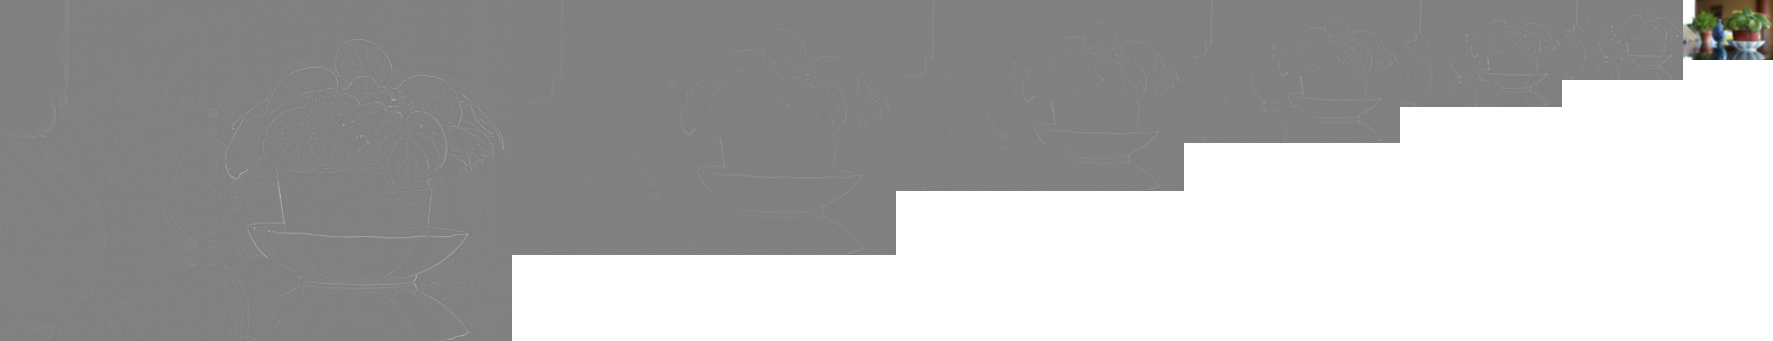

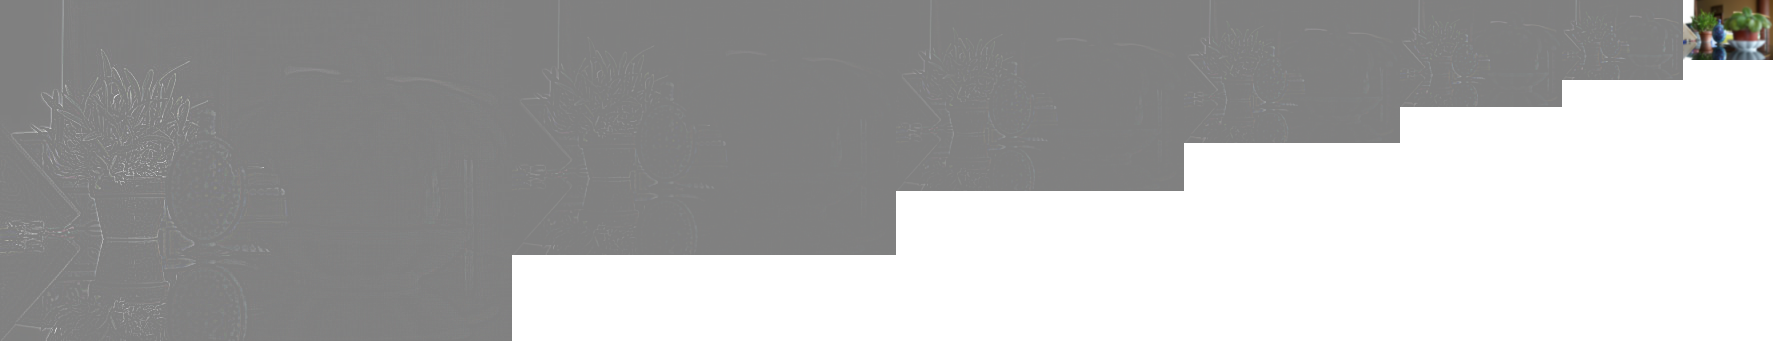

In [10]:
violet = Image.open('violet.jpg')
violet_lap_pyramid = MakeLaplacianPyramid(violet, 0.75, 50)
ShowLaplacianPyramid(violet_lap_pyramid)

orchid = Image.open('orchid.jpg')
orchid_lap_pyramid = MakeLaplacianPyramid(orchid, 0.75, 50)
ShowLaplacianPyramid(orchid_lap_pyramid)

## *Question 4*

In [55]:
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
  # initialize gauss pyramid with last layer of lap pyramid
  gaussian_pyramid = []
  image = lPyramid[-1]
  gaussian_pyramid.append(image)

  i = len(lPyramid) - 1

  # iterate over lap pyramid in reverse
  while i > 0:
    # get dimensions of current layer
    laplacian_layer = lPyramid[i-1]
    width = laplacian_layer.width
    height = laplacian_layer.height

    # upsample the current gauss image to the size of the lap layer
    upsample = np.array(Image.fromarray(np.uint8(image)).resize((width,height), Image.BICUBIC)).astype(np.float32)
    # add the lap layer to the upsampled gauss image
    gaussian_layer = np.clip(upsample + np.array(laplacian_layer).astype(np.float32), 0, 255).astype(np.uint8)
    # convert back to PIL image and insert at the beginning of the gauss pyramid
    gaussian_pyramid.insert(0, Image.fromarray(gaussian_layer))

    image = Image.fromarray(gaussian_layer)
    i = i - 1

  return gaussian_pyramid

Violet Gaussian Pyramid


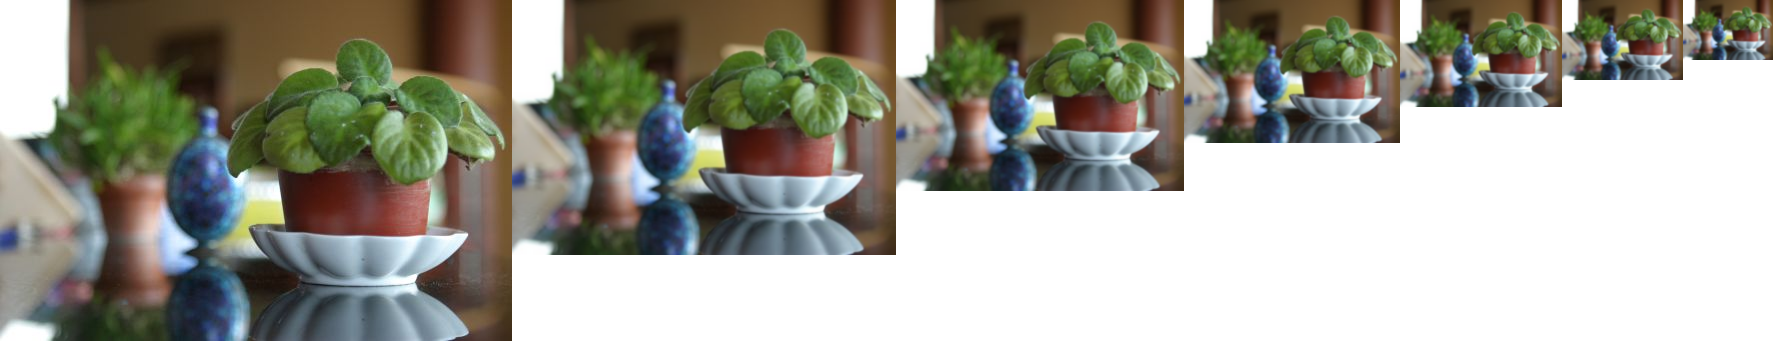

Violet Reconstructed Gaussian Pyramid


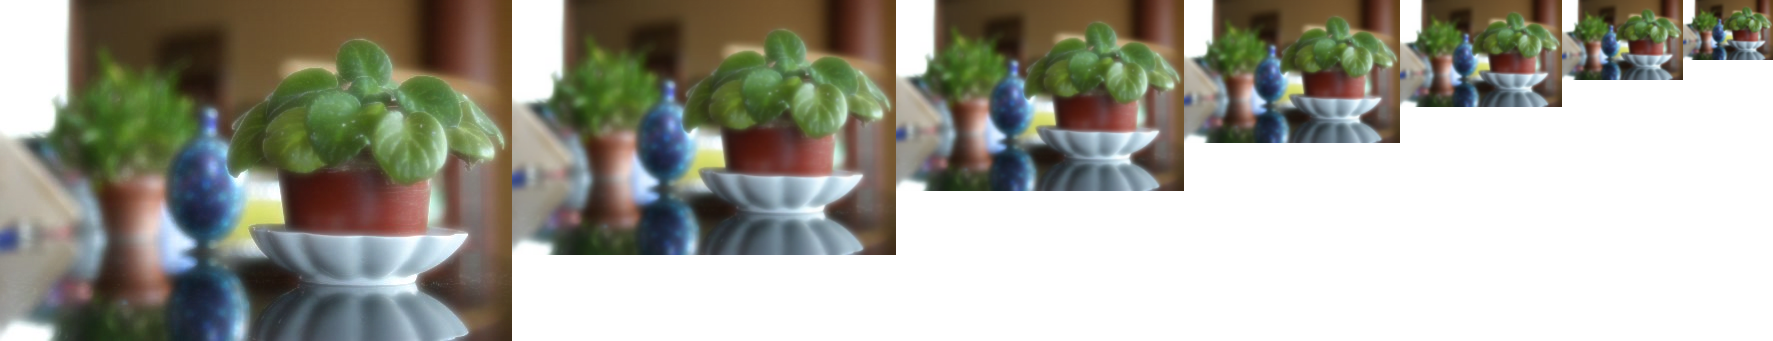

Orchid Gaussian Pyramid


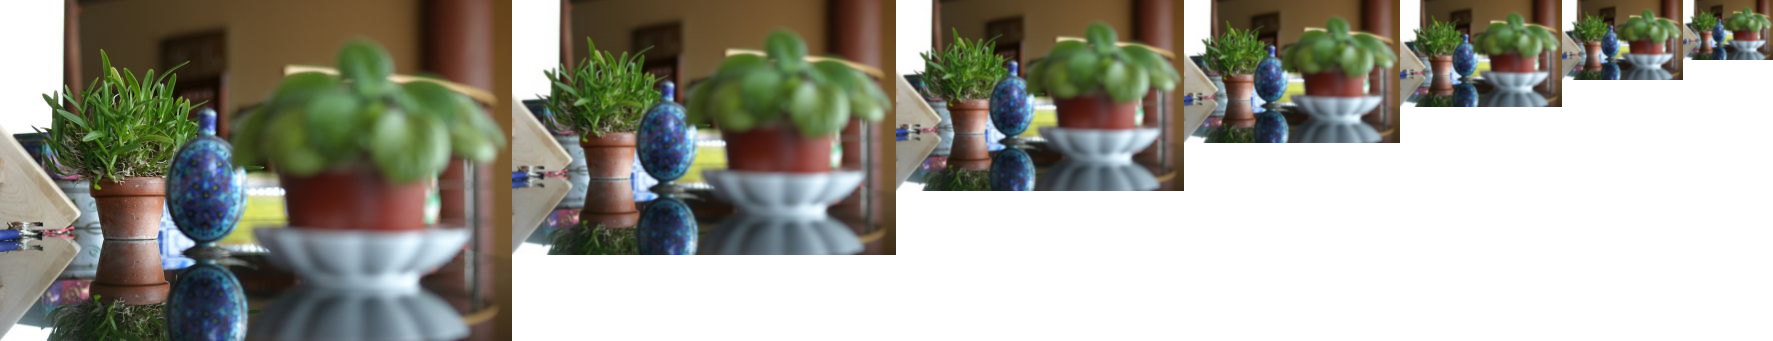

Orchid Reconstructed Gaussian Pyramid


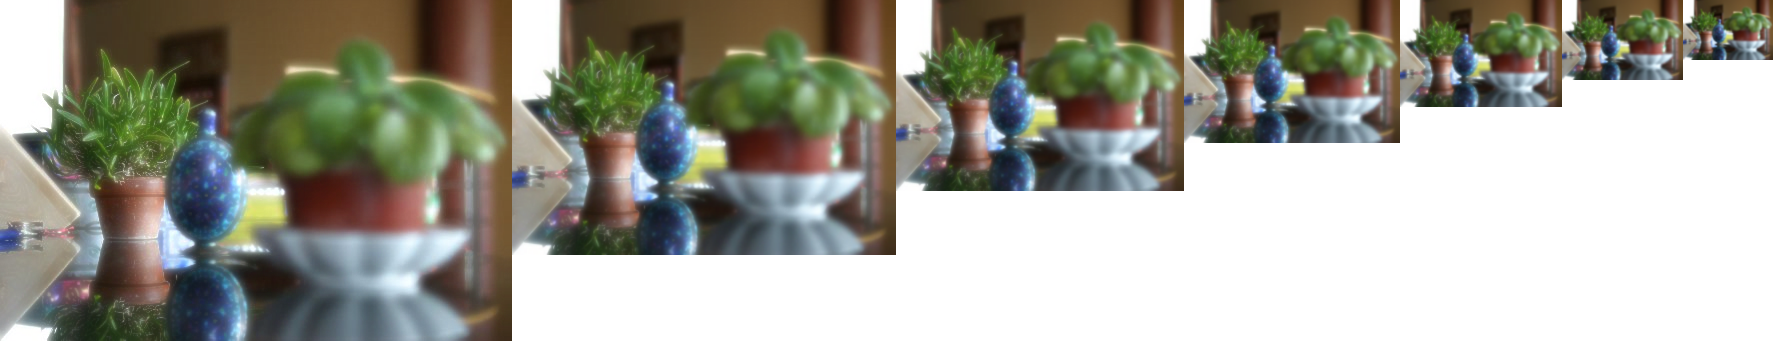

In [56]:
print("Violet Gaussian Pyramid")
violet_pyramid = MakeGaussianPyramid(violet, 0.75, 50)
ShowGaussianPyramid(violet_pyramid)

print("Violet Reconstructed Gaussian Pyramid")
violet_lPyramid = MakeLaplacianPyramid(violet, 0.75, 50)
violet_pyramid = ReconstructGaussianFromLaplacianPyramid(violet_lPyramid)
ShowGaussianPyramid(violet_pyramid)

print("Orchid Gaussian Pyramid")
orchid_pyramid = MakeGaussianPyramid(orchid, 0.75, 50)
ShowGaussianPyramid(orchid_pyramid)

print("Orchid Reconstructed Gaussian Pyramid")
orchid_lPyramid = MakeLaplacianPyramid(orchid, 0.75, 50)
orchid_pyramid = ReconstructGaussianFromLaplacianPyramid(orchid_lPyramid)
ShowGaussianPyramid(orchid_pyramid)

## *Question 5*

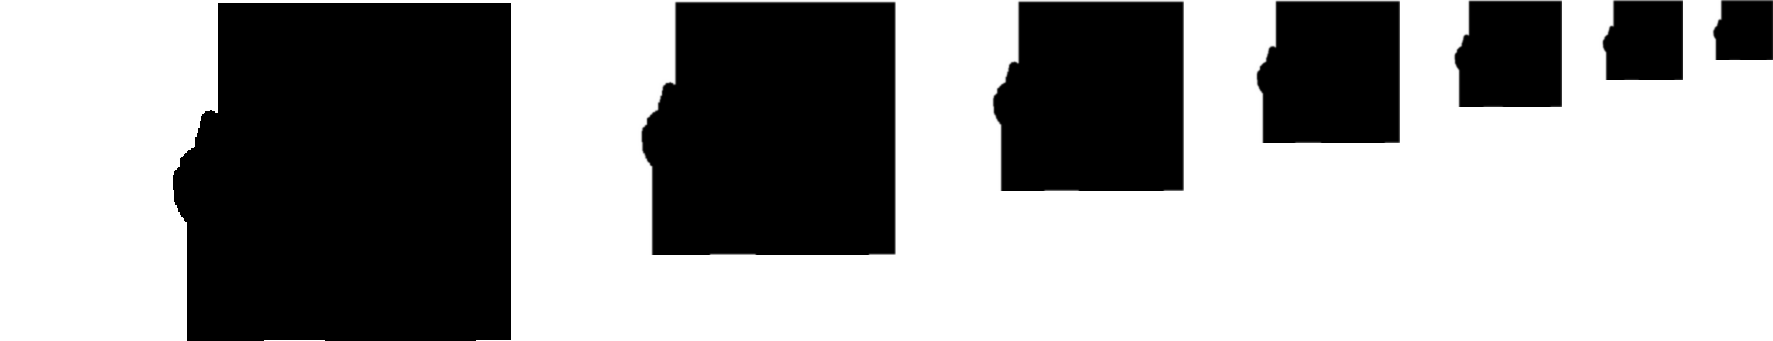

In [13]:
orchid_mask = Image.open('orchid_mask.bmp').convert("RGB")
orchid_mask_pyramid = MakeGaussianPyramid(orchid_mask, 0.75, 50)
ShowGaussianPyramid(orchid_mask_pyramid)

## *Question 6*

In [14]:
def ComposeLapPyramid(lPyramidA, lPyramidB, mask):
  compLaplacian = []

  # iterate through each layer in lap pyramids
  for i in range(len(lPyramidA)):
    # convert to float32 for computation
    lapA = np.array(lPyramidA[i], dtype=np.float32)
    lapB = np.array(lPyramidB[i], dtype=np.float32)
    gaussianM = np.array(mask[i], dtype=np.float32)/255 # normalizing mask to [0,1]

    # compute composite lap layer
    compLap = lapA * gaussianM +  lapB * (1 - gaussianM)
    # clip values between [0,255] to avoid artifacts
    compLap = np.clip(compLap, 0, 255).astype(np.uint8)
    # append the composite layer as a PIL image to the composite lap pyramid
    compLaplacian.append(Image.fromarray(compLap))


  return compLaplacian

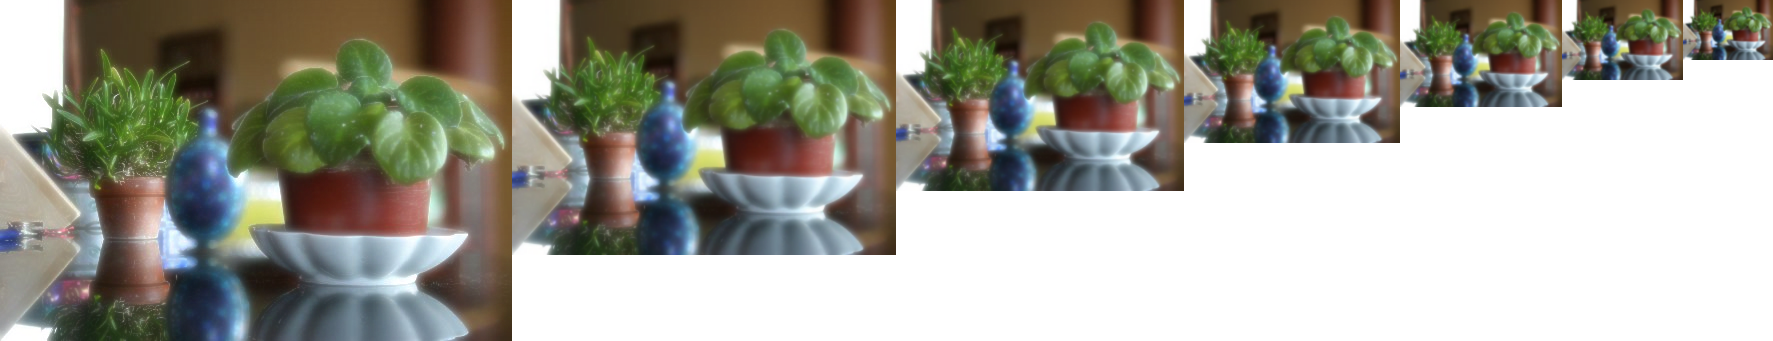

In [15]:
violet_lap_pyramid = MakeLaplacianPyramid(violet, 0.75, 50)
orchid_lap_pyramid = MakeLaplacianPyramid(orchid, 0.75, 50)
composed_lap_pyramid = ComposeLapPyramid(orchid_lap_pyramid, violet_lap_pyramid, orchid_mask_pyramid)
reconstructed_violet_orchid = ReconstructGaussianFromLaplacianPyramid(composed_lap_pyramid)
ShowGaussianPyramid(reconstructed_violet_orchid)

## *Question 7*

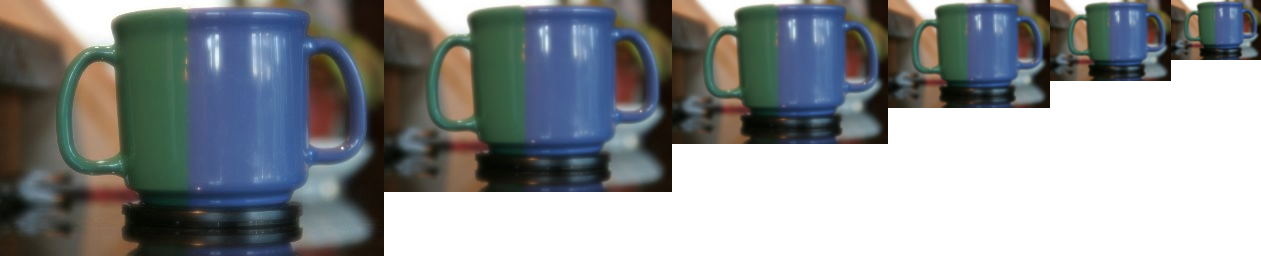

In [16]:
cup_mask = Image.open('cup_mask.bmp').convert("RGB")
cup_mask_pyramid = MakeGaussianPyramid(cup_mask, 0.75, 50)

blue_cup = Image.open('blue_cup.jpg')
blue_cup_lap_pyramid = MakeLaplacianPyramid(blue_cup, 0.75, 50)

green_cup = Image.open('green_cup.jpg')
green_cup_lap_pyramid = MakeLaplacianPyramid(green_cup, 0.75, 50)

composed_lap_pyramid = ComposeLapPyramid(green_cup_lap_pyramid, blue_cup_lap_pyramid, cup_mask_pyramid)
reconstructed_cup = ReconstructGaussianFromLaplacianPyramid(composed_lap_pyramid)
ShowGaussianPyramid(reconstructed_cup)

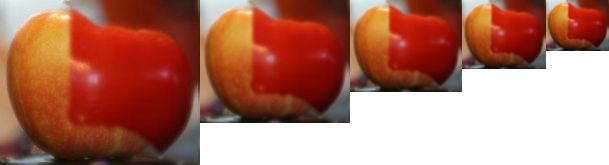

In [17]:
tomato_mask = Image.open('tomato_mask.bmp').convert("RGB")
tomato_mask_pyramid = MakeGaussianPyramid(tomato_mask, 0.75, 50)

apple = Image.open('apple.jpg')
apple_lap_pyramid = MakeLaplacianPyramid(apple, 0.75, 50)

tomato = Image.open('tomato.jpg')
tomato_lap_pyramid = MakeLaplacianPyramid(tomato, 0.75, 50)

composed_lap_pyramid = ComposeLapPyramid(apple_lap_pyramid, tomato_lap_pyramid, tomato_mask_pyramid)
reconstructed_tomato_apple = ReconstructGaussianFromLaplacianPyramid(composed_lap_pyramid)
ShowGaussianPyramid(reconstructed_tomato_apple)